In [30]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import FuncAnimation, PillowWriter
from typing import Dict, Tuple, List



In [2]:
EMPTY = 0
ALPHA = 4

In [3]:
def schelling_model(grid: np.ndarray, max_iter: int) -> List[np.ndarray]:
    grids = [grid]
    agent_types = np.unique(grid)
    updated = True
    i = 0
    while updated and i < max_iter:
        grid, updated = schelling_ca(grid, agent_types)
        grids.append(grid)
        i += 1
    return grids

In [4]:
def schelling_ca(grid: np.ndarray, agent_types: np.ndarray) -> Tuple[np.ndarray, bool]:
    neigh_fractions = {a_type: compute_fractions(grid, a_type) for a_type in agent_types}
    # return relocate_agents(np.copy(grid), neigh_fractions)
    return gather_preferences_and_relocate(np.copy(grid), neigh_fractions)


In [5]:
def compute_fractions(grid: np.ndarray, agent_type: int) -> np.ndarray:
    n_rows, n_cols = grid.shape
#     fractions = np.empty(grid.shape)
    fractions = dict()
    for i in range(n_rows):
        for j in range(n_cols):
            neigh = neighbourhood(grid, i, j)
            n_preffered = np.count_nonzero(neigh == agent_type)
            n_all = np.count_nonzero(neigh != EMPTY)
            fractions[i, j] = (n_preffered, n_all)# if n_all else 0
    return fractions

In [6]:
def relocate_agents(grid: np.ndarray, fractions: Dict[int, np.ndarray]) -> Tuple[np.ndarray, bool]:
    n_rows, n_cols = grid.shape
    rows, cols = list(range(n_rows)), list(range(n_cols))
    np.random.shuffle(rows), np.random.shuffle(cols)
    relocated = False
    for i in rows:
        for j in cols:
            agent_type = grid[i, j]
            n_preffered, n_all = fractions[agent_type][i,j][0], fractions[agent_type][i,j][1]
            b = n_preffered / n_all if n_all else 1
            if agent_type != EMPTY and b < ALPHA:
                neigh = neigh_indices(grid, i, j)
                new_indices = find_better_spot(grid, fractions[agent_type], i, j)
                if new_indices:
                    grid[new_indices] = agent_type
                    grid[i, j] = EMPTY
                    relocated = True
    return grid, relocated

In [7]:
def find_better_spot(grid: np.ndarray, fractions: np.ndarray, i: int, j: int) -> Tuple[int, int]:
    neigh_coords = neigh_indices(grid, i, j)
    np.random.shuffle(neigh_coords)
    for row, col in neigh_coords:
        n_preffered, n_all = fractions[row, col][0] - 1, fractions[row, col][1] - 1
        b = n_preffered / n_all if n_all else 1
        if grid[row, col] == EMPTY and b >= ALPHA:
            return row, col
    
    n_preffered, n_all = fractions[i, j][0], fractions[i, j][1]
    self_b = n_preffered / n_all if n_all else 1
    for row, col in neigh_coords:
        n_preffered, n_all = fractions[row, col][0] - 1, fractions[row, col][1] - 1
        b = n_preffered / n_all if n_all else 1
        if grid[row, col] == EMPTY and b > self_b:
            return row, col


In [18]:
def check_for_preference_conflicts(preferences: dict) -> dict:
    for key in preferences.keys():
        elem = preferences.get(key)
        #print("Elem: ", elem)
        if len(elem) > 1 :
            #print("Longer than 1:", preferences.pop(key))
            preferences.pop(key)
    
    return preferences

In [19]:
# {miejsce: [agent1, agent2]} agent saved as location (row, col)

def gather_preferences_and_relocate(grid: np.ndarray, fractions: np.ndarray)  -> Tuple[np.ndarray, bool]:
    n_rows, n_cols = grid.shape
    rows, cols = list(range(n_rows)), list(range(n_cols))
    gathered_preferences ={}
    relocated = False 

    for i in rows:
        for j in cols:
            agent_type = grid[i, j]
            n_preffered, n_all = fractions[agent_type][i,j][0], fractions[agent_type][i,j][1]
            b = n_preffered / n_all if n_all else 1
            if agent_type != EMPTY and b < ALPHA:# check if there's an agent here, then:
                new_location = find_better_spot(grid, fractions[agent_type], i, j) # returns a tuple (row, col)
                # Now append that new location (as a key) to the dict, values are lists of agents (saved as location)\
                # If the list is longer than 1 elem then we will drop it
                #print(new_location)
                gathered_preferences[new_location] = list()
                gathered_preferences[new_location].append((i, j))

    preferences = check_for_preference_conflicts(gathered_preferences)
    if preferences:
        for key, value in preferences.items():
            if key == None:
                continue
            #print(key, "->", value[0])
            grid[key] = grid[value[0]]
            grid[value[0]] = EMPTY 
        relocated = True
    
    return grid, relocated


In [10]:
def execute_relocation_with_preferences(grid: np.ndarray, fractions: Dict[int, np.ndarray]) -> Tuple[np.ndarray, bool]:
    n_rows, n_cols = grid.shape
    rows, cols = list(range(n_rows)), list(range(n_cols))
    np.random.shuffle(rows), np.random.shuffle(cols)
    relocated = False
    
    agents = list()

In [11]:
def neighbourhood(grid: np.ndarray, i: int, j: int) -> np.ndarray:
    return np.array([grid[i, j] for i, j in neigh_indices(grid, i, j)])


In [12]:
def neigh_indices(grid: np.ndarray, i: int, j: int) -> List[Tuple[int, int]]:
    n, _ = grid.shape
    candidates = [
        (i-1, j-1),
        (i-1, j),
        (i-1, j+1),
        (i, j-1),
        (i, j+1),
        (i+1, j-1),
        (i+1, j),
        (i+1, j+1),
    ]
    return [(i,j) for (i,j) in candidates if i>=0 and j>=0 and i<n and j<n]

In [13]:

colors = [(1, 1, 1), (1, 0, 0), (0, 0, 1)]
cmap = LinearSegmentedColormap.from_list('cmap', colors, N=3)
def plot_grid(grid: np.ndarray):
    return plt.imshow(grid, cmap=cmap)    

In [14]:
def visualize(grids: List[np.ndarray]):
    fig = plt.figure(figsize=(10,10))
    im = plot_grid(grids[0])
    ani = FuncAnimation(fig, plot_grid, grids)
    writergif = PillowWriter(fps=5) 
    ani.save(f'animation.gif', writer=writergif)
    fig.colorbar(im)
    plt.show()

In [25]:
def plot_first_last_step(grids: List[np.ndarray]):
    fig1 = plt.figure(figsize=(5, 5))
    im1 = plot_grid(grids[0])
    fig1.colorbar(im1)

    fig2 = plt.figure(figsize=(5, 5))
    im2 = plot_grid(grids[-1])
    fig2.colorbar(im2)

    plt.show()

In [15]:

def create_grid(size: int, densities: Dict[int, float]) -> np.ndarray:
    grid = []
    for field_type, density in densities.items():
        n_fields = int(size * size * density)
        grid += [field_type for _ in range(n_fields)]
    grid += [EMPTY for _ in range(size * size - len(grid))]
    np.random.shuffle(grid)
    return np.array(grid).reshape((size, size))

In [16]:
n_all = 110_000
white = 60_371 / n_all
black = 14_675 / n_all
empty = 1 - white - black
initial = create_grid(100, {1: white, 2: black})

In [20]:
grids = schelling_model(initial, max_iter=1000)


## Visualisation:

KeyboardInterrupt: 

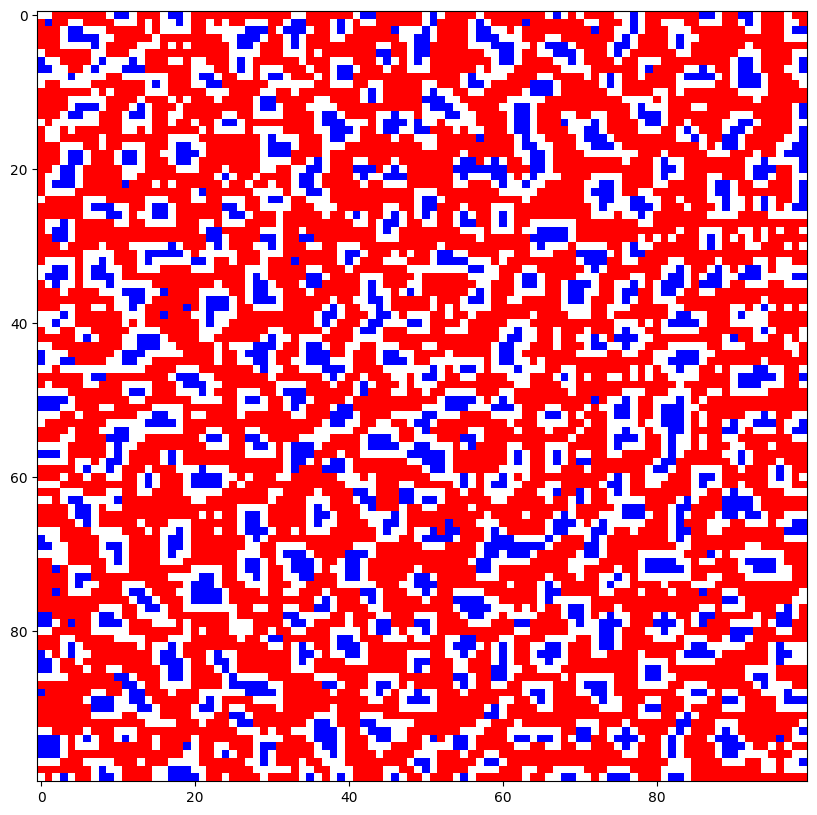

In [21]:
visualize(grids)

### 20x20, p={0.35, 0.45, 0.55, 0.65}, agents 50/50

Probability p: 0.35


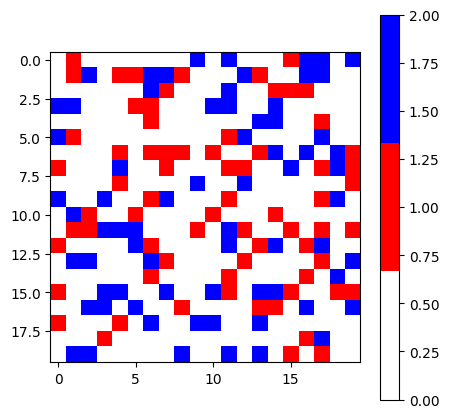

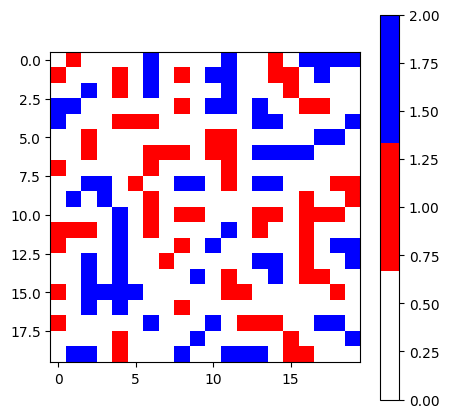

Probability p: 0.45


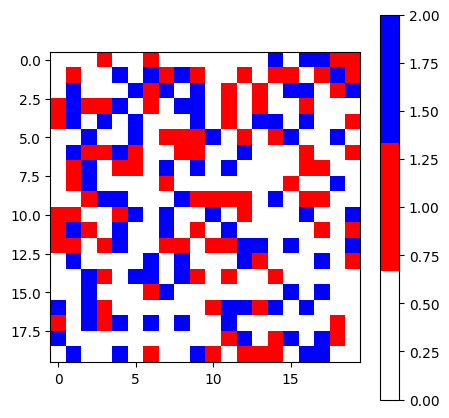

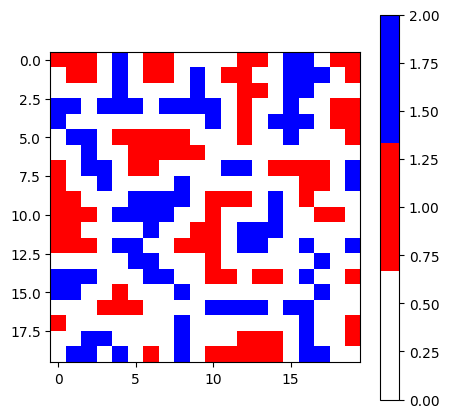

Probability p: 0.55


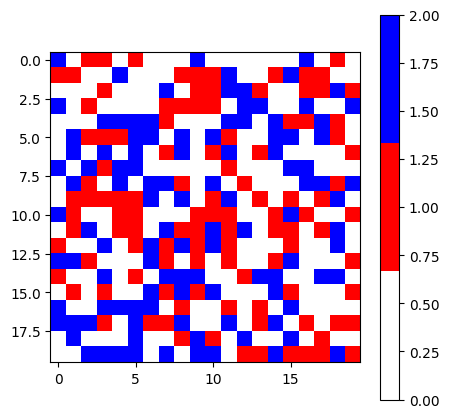

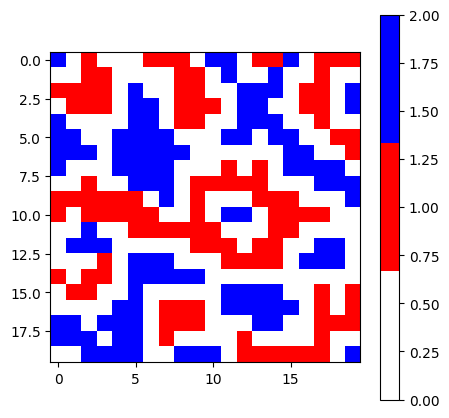

Probability p: 0.65


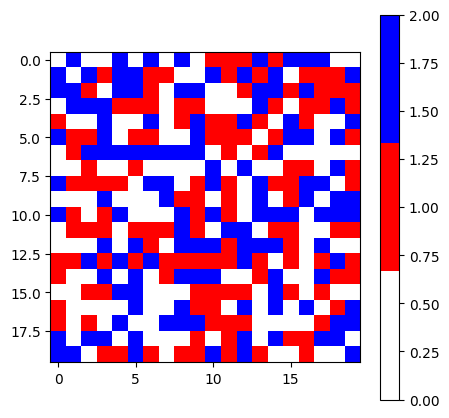

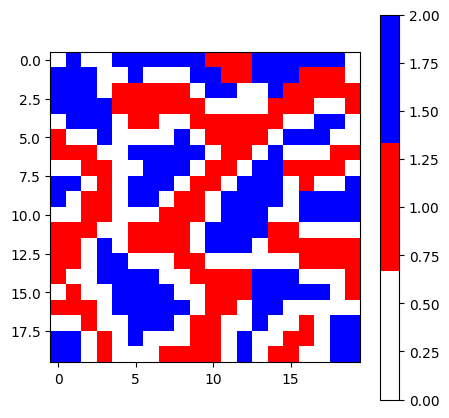

In [26]:
for p in [0.35, 0.45, 0.55, 0.65]:
    reds = p/2

    blues = p/2

    empty = 1 - reds - blues

    initial_grid_20x20 = create_grid(size=20, densities={1: reds, 2:blues})
    grids = schelling_model(initial_grid_20x20, max_iter=3000)
    print("Probability p:", p)
    plot_first_last_step(grids)


### 50x50, p={0.35, 0.45, 0.55, 0.65}, agents 25/75

Probability p: 0.35


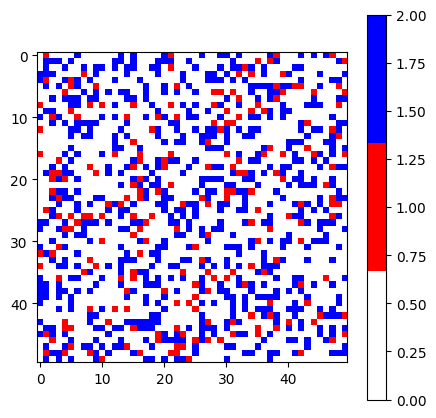

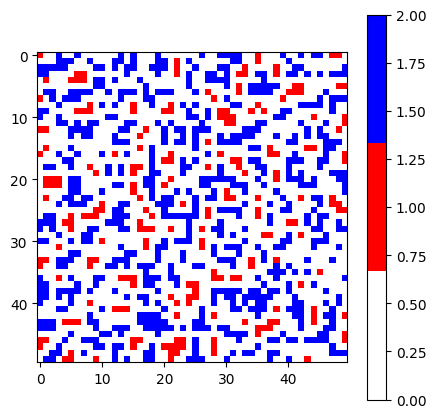

Probability p: 0.45


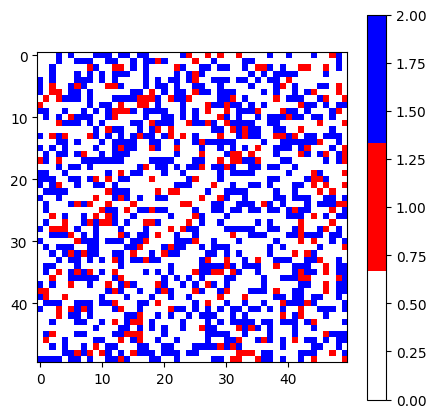

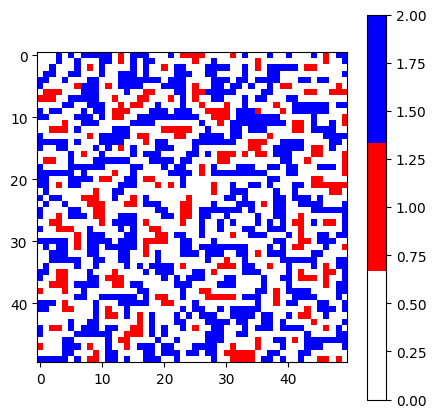

Probability p: 0.55


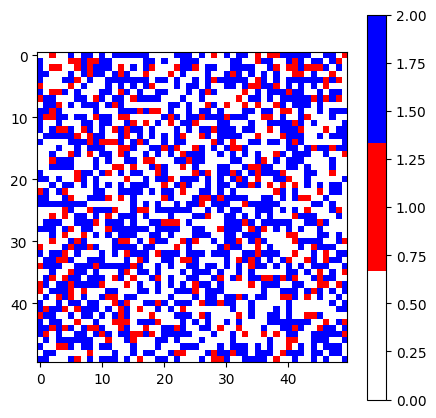

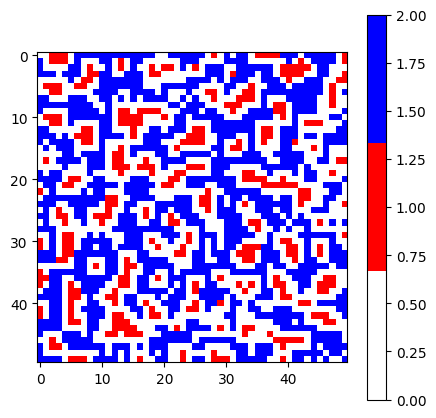

Probability p: 0.65


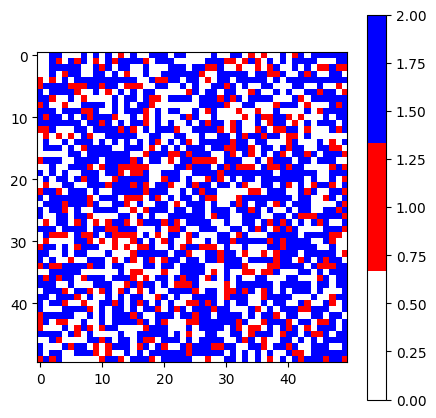

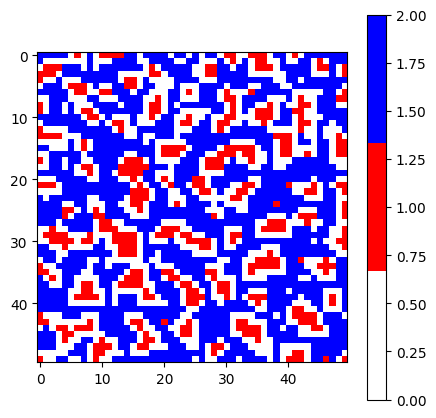

In [28]:
for p in [0.35, 0.45, 0.55, 0.65]:
    reds = p/4

    blues = (p*3)/4

    empty = 1 - reds - blues

    initial_grid_100x100 = create_grid(size=50, densities={1: reds, 2:blues})
    print("Probability p:", p)
    grids = schelling_model(initial_grid_100x100, max_iter=3000)
    plot_first_last_step(grids)

### 50x50, p={0.35, 0.5, 0.75}, agents 25/25/25/25

In [45]:
colors = [(1, 1, 1), (1, 0, 0), (0, 0, 1), (0,1,0), (1,1,0)]
cmap = LinearSegmentedColormap.from_list('cmap', colors, N=5)
# cmap = mpl.colormaps['hsv']
def plot_grid(grid: np.ndarray):
    return plt.imshow(grid, cmap=cmap)    

Probability p: 0.35


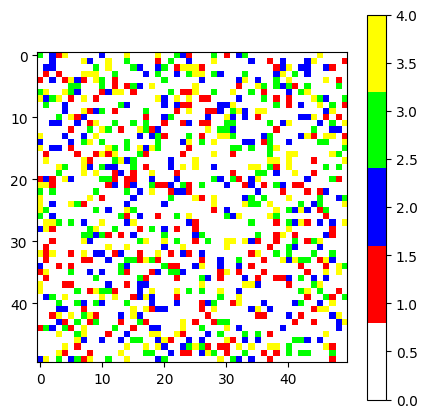

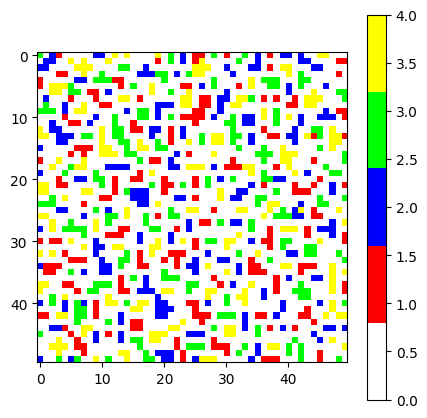

Probability p: 0.5


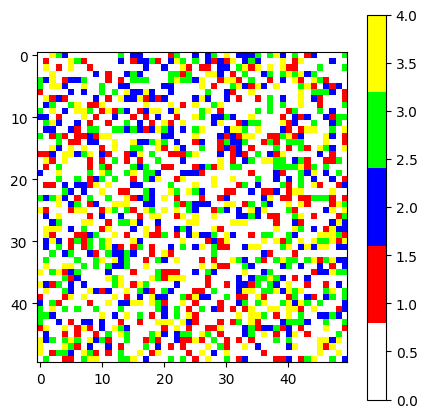

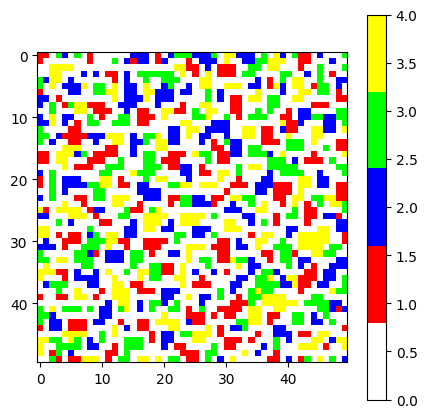

Probability p: 0.75


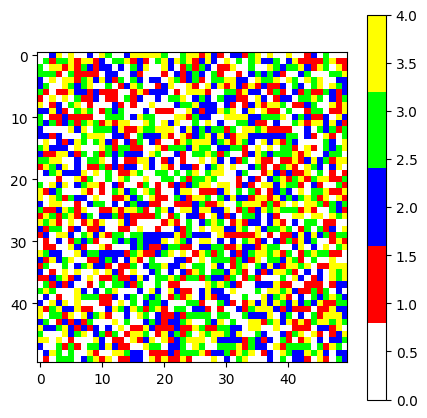

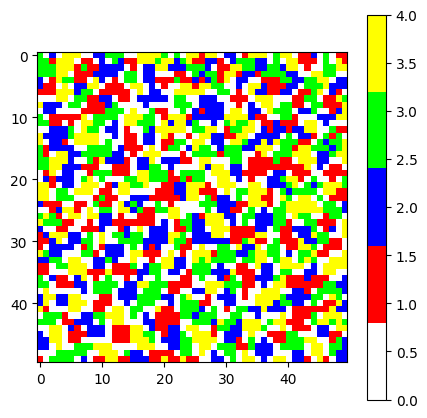

In [46]:
for p in [0.35, 0.5, 0.75]:
    reds = p/4
    blues = p/4
    greens = p/4
    yellows = p/4

    empty = 1 - reds - blues - yellows - greens

    initial_grid_100x100 = create_grid(size=50, densities={1: reds, 2:blues, 3:greens, 4:yellows})
    print("Probability p:", p)
    grids = schelling_model(initial_grid_100x100, max_iter=3000)
    plot_first_last_step(grids)
